$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# Demonstration of the principle of superposition

Teslamax model:

<img src="figures/teslamax.png" width=500>

Tell the location of the TeslaMax Java class file:

In [1]:
from pathlib import Path
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign,TeslaMaxModel
import nemplot

## Playground

In [2]:
os.chdir('C:\\Users\\fabiofortkamp\\code\\TeslaMax\\')

In [3]:
teslamax_playground = "teslamax-play"


In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

We wish to demonstrate the Principle of Superposition to the TeslaMax model.

We define a sample geometry, with only one segment in each cylinder.

In [5]:
param_dict = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 0.3,
                "n_IV": 1,
                "phi_S_IV": 45,
                "n_II": 1,
                "phi_C_II": 0,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "mu_r_IV": 1.05,
                "linear_iron": 1,
                "mu_r_iron": 5e3,
             }

alpha_rem_vector = np.array([15, 15])

tmpd = TeslaMaxPreDesign(param_dict)

We "run" the TeslaMax model:

In [6]:
tmm = TeslaMaxModel(tmpd, alpha_rem_vector,
                   path=teslamax_playground)

In [7]:
%%time

tmm.run()

Wall time: 17.5 s


We define an arbitrary point in the air gap region

In [8]:
x_gap = param_dict["R_o"] + 0.5 * param_dict["h_gap"]
y_gap = 0
point_gap = np.array([x_gap,y_gap])

Then we calculate the value of $\nvb$ in the air gap at that position:

In [9]:
%%time

B_total = tmm.calculate_B_III_from_position(point_gap)[0]
B_total

Wall time: 998 µs


In the `teslamax` library, there is a function which performs a FEM simulation to calculate the $\nvector{F}^B_{\mathrm{rem},m,k}$ operator, which represents the contribution of segment $k$ in magnet $m$ to the magnetic flux density in the air gap.

With this function we can calculate te contribution of the only segment in magnet IV, passing the properties of the above dictionary. Notice that because `param_dict` defines one segment in each magnet, this cell below will nulify the remanence of magnet II:

In [10]:
%%time
B_outer = tmpd.calculate_B_III_from_single_block(point=point_gap,
                                           angle=alpha_rem_vector[1],
                                           magnet='IV',
                                           magnitude=param_dict["B_rem_IV_1"],
                                            segment=1)[0]
B_outer

Wall time: 18.4 s


Now we do the same, but calculating the effect of the single block in the inner magnet:

In [11]:
%%time

B_inner = tmpd.calculate_B_III_from_single_block(point=point_gap,
                                           angle=alpha_rem_vector[0],
                                           magnet='II',
                                           magnitude=param_dict["B_rem_II_1"],
                                            segment=1)[0]
B_inner

Wall time: 18.4 s


The total field should be the sum of the "partial" fields calculated below:

In [12]:
B_total - (B_outer + B_inner)

array([  1.55431223e-15,  -1.75554016e-15])

Notice that this is not exactly zero due to interpolation errors (since for each condition that is a mesh generation, and an interpolation scheme to find the field at the desired point). However, in relation to the total field:

In [13]:
(B_total - (B_outer + B_inner))/B_total * 100 # in percentage


array([  1.46669568e-13,  -1.76912274e-10])

## Calculating over a cloud of points

In [14]:
%%time

param_dict = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 0.3,
                "n_IV": 1,
                "phi_S_IV": 45,
                "n_II": 1,
                "phi_C_II": 0,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "mu_r_IV": 1.05,
                "linear_iron": 1,
                "mu_r_iron": 5e3,
             }

alpha_rem_vector = np.array([15, 15])

tmpd = TeslaMaxPreDesign(param_dict)

tmm = TeslaMaxModel(tmpd, alpha_rem_vector,
                   path=teslamax_playground)

tmm.run()

R_o = param_dict["R_o"]
R_g = R_o + param_dict["h_gap"]

points_gap = teslamax.generate_sector_mesh_points(R_o,R_g,0,np.pi/2)

B_total = tmm.calculate_B_III_from_position(points_gap)

B_inner = tmpd.calculate_B_III_from_single_block(point=points_gap,
                                           angle=alpha_rem_vector[0],
                                           magnet='II',
                                           magnitude=param_dict["B_rem_II_1"],
                                            segment=1)

B_outer = tmpd.calculate_B_III_from_single_block(point=points_gap,
                                           angle=alpha_rem_vector[1],
                                           magnet='IV',
                                           magnitude=param_dict["B_rem_IV_1"],
                                            segment=1)



Wall time: 56.2 s


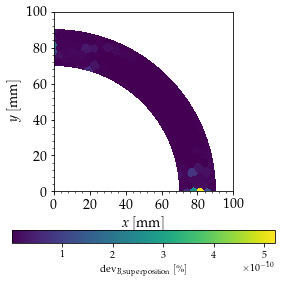

In [15]:
%matplotlib inline

nemplot.set_figsize_cm(12)
nemplot.set_latex_font('Palatino')
nemplot.set_fontsize(14)

fig, axes = nemplot.create_plot(xlabel=r'$x\,[\si{\milli\meter}]$',
                                 ylabel=r'$y\,[\si{\milli\meter}]$')
axes.set_aspect('equal')
axes.set_xlim(0,1e3*R_g)
axes.set_ylim(0,1e3*R_g)
nemplot.refine_xticks(axes,5)
nemplot.refine_yticks(axes,5)
x_vector, y_vector = 1e3*points_gap.T

#pcolormesh deals with 2D arrays, so we reshape our vectors
number_of_points_per_axes = int(math.sqrt(len(x_vector)))
mesh_shape = ( number_of_points_per_axes, number_of_points_per_axes)

dev_B_superposition = (B_total - (B_outer + B_inner))/B_total * 100
dev_B_x, dev_B_y = dev_B_superposition.T

dev_B_superposition_magnitude = teslamax.calculate_magnitude(np.array([x_vector,
                                                            y_vector,
                                                            dev_B_x,
                                                            dev_B_y]).T).T[2]

B_mesh = axes.pcolormesh(x_vector.reshape(mesh_shape),
                        y_vector.reshape(mesh_shape),
                           dev_B_superposition_magnitude.reshape(mesh_shape))

#annotate the plot
B_colorbar = fig.colorbar(B_mesh,orientation='horizontal')
B_colorbar.set_label(r'$\mathrm{dev}_{B,\mathrm{superposition}}\ [\si{\percent}]$')
